In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

from imblearn.over_sampling import SMOTE
 
from geopy.distance import geodesic
import joblib

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
df.shape

(1296675, 23)

In [4]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [5]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month


In [6]:
drop_col = ["Unnamed: 0", "trans_date_trans_time", "first", 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num']
df =df.drop(columns=drop_col)

In [7]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",1325376018,36.011293,-82.048315,0,0,1,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,1325376044,49.159047,-118.186462,0,0,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,Nature conservation officer,1325376051,43.150704,-112.154481,0,0,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,Patent attorney,1325376076,47.034331,-112.561071,0,0,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,1325376186,38.674999,-78.632459,0,0,1,1


In [8]:
df[df['is_fraud']==1]

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
2449,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,M,35.9946,-81.7266,885,Soil scientist,1325466397,36.430124,-81.179483,1,1,2,1
2472,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,F,29.4400,-98.4590,1595797,Horticultural consultant,1325468849,29.819364,-99.142791,1,1,2,1
2523,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,F,29.4400,-98.4590,1595797,Horticultural consultant,1325473523,29.273085,-98.836360,1,3,2,1
2546,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,M,35.9946,-81.7266,885,Soil scientist,1325475483,35.909292,-82.091010,1,3,2,1
2553,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,F,29.4400,-98.4590,1595797,Horticultural consultant,1325476547,29.786426,-98.683410,1,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,3524574586339330,fraud_Kassulke PLC,shopping_net,977.01,F,27.6330,-80.4031,105638,"Librarian, public",1371776408,26.888686,-80.834389,1,1,21,6
1295491,3524574586339330,fraud_Schumm PLC,shopping_net,1210.91,F,27.6330,-80.4031,105638,"Librarian, public",1371779615,28.216707,-79.855648,1,1,21,6
1295532,4005676619255478,"fraud_Tillman, Dickinson and Labadie",gas_transport,10.24,M,30.4590,-90.9027,71335,Herbalist,1371781016,29.700456,-91.361632,1,2,21,6
1295666,3560725013359375,fraud_Corwin-Collins,gas_transport,21.69,F,31.8599,-102.7413,23,Cytogeneticist,1371785180,32.675272,-103.484949,1,3,21,6


In [9]:
cat_col = ['merchant', 'gender', 'category']

encoders = {}
for col in cat_col:
    encoders[col] = LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    distances = []
    for a, b, c, d in zip(lat1, lon1, lat2, lon2):
        try:
            distances.append(geodesic((a, b), (c, d)).km)
        except:
            distances.append(np.nan)
    return np.array(distances)


In [11]:
df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,"Psychologist, counselling",1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,Special educational needs teacher,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,Nature conservation officer,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,Patent attorney,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,Dance movement psychotherapist,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [12]:
features = ['merchant', 'category', 'amt', 'cc_num', 'hour', 'day', 'month', 'gender', 'distance']
x = df[features]
y = df['is_fraud'] 

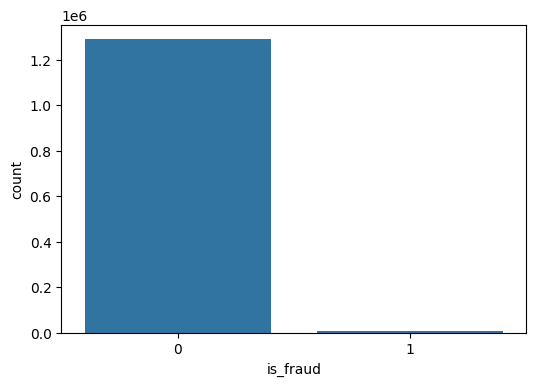

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.show()

In [14]:
smote = SMOTE(random_state=42)

x_resample, y_resample = smote.fit_resample(x,y)

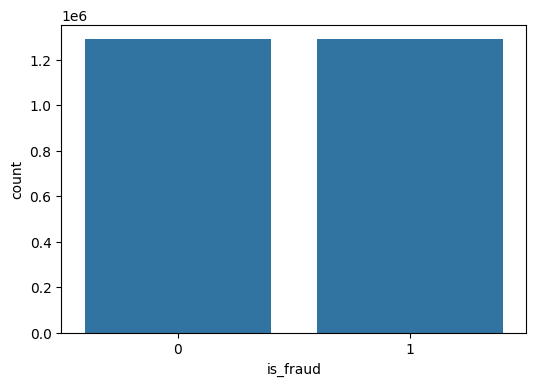

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.show()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, train_size=0.2, random_state=42)

In [17]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics = 'auc',
    is_unbalance = True,
    learning_rate= 0.05,
    num_leaves= 31,
    max_depth=5,
    n_estimators=200
    )

lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 258016, number of negative: 257651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 515667, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500354 -> initscore=0.001416
[LightGBM] [Info] Start training from score 0.001416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=5,
               metrics='auc', n_estimators=200, objective='binary')

In [18]:
y_pred = lgb_model.predict(x_test)

In [19]:
print('classification_report : \n', classification_report(y_test, y_pred))


classification_report : 
               precision    recall  f1-score   support

           0       0.90      0.97      0.94   1031518
           1       0.97      0.90      0.93   1031153

    accuracy                           0.93   2062671
   macro avg       0.94      0.93      0.93   2062671
weighted avg       0.94      0.93      0.93   2062671



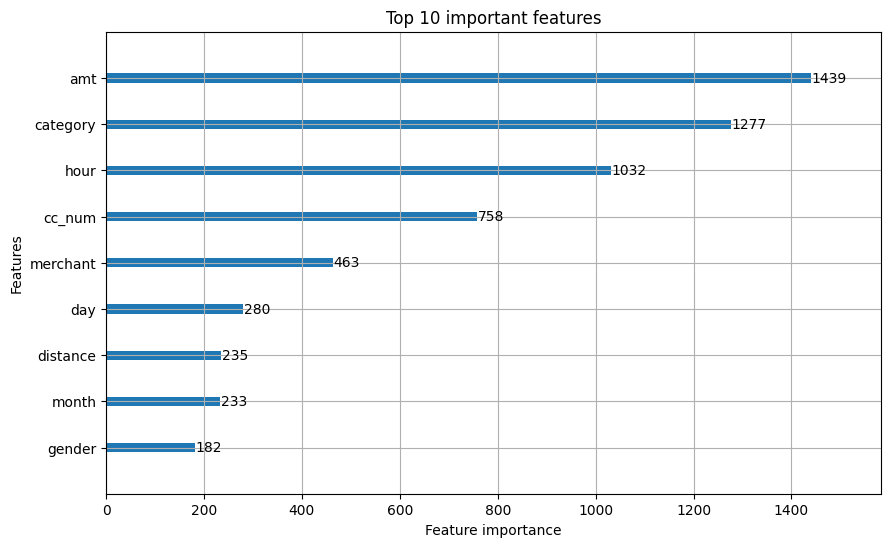

In [20]:
lgb.plot_importance(lgb_model, max_num_features=10, figsize=(10,6), importance_type='split')
plt.title("Top 10 important features")
plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

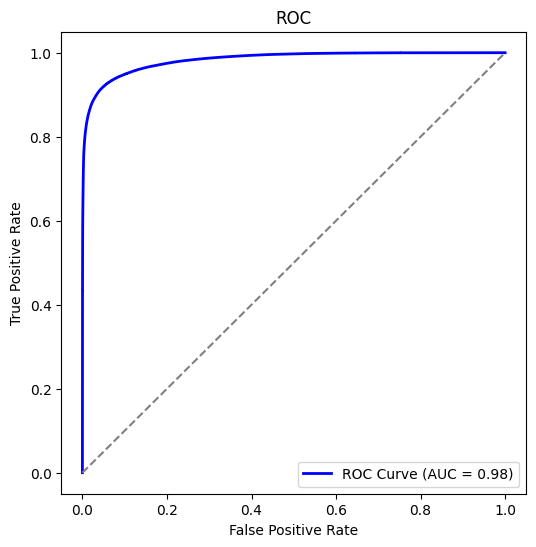

In [22]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw =2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [23]:
joblib.dump(lgb_model, "Fraud_Detection.jb")
joblib.dump(encoders, "label_encoders.jb")

['label_encoders.jb']